# Κατασκευή Νευρωνικού Δικτύου

***

### Εισαγωγή δεδομένων

Για αρχή θα πειραματιστούμε με τα data από το simulation και πολύ απλοϊκά μοντέλα με λίγες παραμέτρους.

Παίρνουμε τα data στα οποία έχουμε εφαρμόσει γραμμική παρεμβολή και δημιουργούμε τα labels που πρέπει τελικά να εντοπιστούν στην μορφή $[x_l, y_l]$

In [1]:
import torch
import sklearn
import pandas as pd
import numpy as np
#import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
Data = pd.read_pickle("Sim_Data_Noisy_Interp.pkl")

rfid_label = (Data['x_tag'], Data['y_tag'])
rfid_label = np.array(rfid_label).T
print(rfid_label.shape)

(1000, 2)


Έπειτα δημιουργούμε έναν πίνακα (tensor) διαστάσεων $(1000, 1000, 4)$ που περιέχει τα 1000 tags που δημιουργήθηκαν από το simulation, τα 1000 time samples από το μήκος των μετρήσεων, και τα 4 χαρακτηριστικά που μας χρειάζονται , [x_robot,y_robot,z_robot,phase_unwrapped].

In [3]:
info_tensor = np.empty((0, 1000, 4))
for i in range(len(rfid_label)):
    Data.loc[i, 'Phases'] = Data.loc[i, 'Phases'].reshape(-1, 1)
    result = np.concatenate((Data.loc[i, 'robot_pos'].T, Data.loc[i, 'Phases'].reshape(-1, 1)), axis=1)
    info_tensor = np.concatenate((info_tensor, result[np.newaxis, :, :]), axis=0)

print(info_tensor.shape)

(1000, 1000, 4)


***

### Data Augmentation μέσω segmentation

Ορίζουμε την συνάρτηση παρακάτω μέσω της οποίας μετασχηματίζουμε κάθε μία μέτρηση σε ένα πλήθος x που μπορούμε να διαλέξουμε εμείς με y αριθμό μετρήσεων στο κάθε ένα. Αυτό συμβαίνει καθώς για κάθε ένα tag σπάμε τις μετρήσεις σε x (όχι απαραίτητα μη επικαλυπτόμενες) μετρήσεις μεγέθους y.

In [4]:
#Take random segments of the full array
def sample_random_segments(tensor1, segment_length, num_samples):
    if len(tensor1) < segment_length:
        raise ValueError("Segment length must be smaller than or equal to array length.")
    
    max_start_index = len(tensor1) - segment_length  # Ensure segment stays within bounds
    start_indices = np.random.randint(0, max_start_index + 1, size=num_samples)

    segments = np.empty((num_samples, segment_length, tensor1.shape[1]))

    for idx, start in enumerate(start_indices):
        segments[idx] = tensor1[start:start+segment_length]
    return segments

In [5]:
num_of_samples = 5 # Number of samples per tag
segment_length = 200 # Length of each segment

info_new = np.empty((0, segment_length, 4))
for i in range(len(info_tensor)):
    temp_info = sample_random_segments(info_tensor[i], segment_length, num_of_samples) 
    info_new = np.concatenate((info_new, temp_info), axis=0)

# Multiply labels
rfid_label = np.repeat(rfid_label, num_of_samples, axis=0)

In [6]:
print(info_new.shape) 
print(rfid_label.shape)

(5000, 200, 4)
(5000, 2)


***

### Linear Interpolation για να έχουμε ίδιο μέγεθος σε όλα τα samples

Μιας και τα δεδομένα μας περιμένουμε να περιέχουν ασυνέχειες, σκεφτόμαστε ότι μέσω της γραμμικής παρεμβολής θα βεβαιωνόμαστε για το σταθερό μήκος του Input στο μοντέλο. Αυτό υλοποιείται παρακάτω.

In [7]:
def lin_interpolation(data, length):
    x = np.linspace(data[0,0],data[-1,0], length)
    
    # Create interpolation results
    result = np.empty((length, data.shape[1]))
    result = np.array([x, np.interp(x, data[:,0], data[:,1]), np.interp(x, data[:,0], data[:,2]), np.interp(x, data[:,0], data[:,3])]).T
    return result

Έχοντας πλέον την συνάρτηση που θα δημιουργήσει τα δεδομένα μετατρέπουμε τον πίνακα των samples στον τελικό πίνακα που θα μπει στο μοντέλο.

In [8]:
interp_length = 1000
input_array = np.empty((info_new.shape[0],interp_length, 4))

for i in range(len(info_new)):
    input_array[i] = lin_interpolation(info_new[i], interp_length)

input_array.shape

(5000, 1000, 4)

***

### Προβλέψεις μέσω XGB

Τo XGB δεν υποστηρίζει πολυδιάστατη είσοδο όπως θα θέλαμε καθώς υπάρχει χρονική συσχέτιση μεταξύ των δεδομένων. Επίσης δεν υποστηρίζει πολυδιάστατη έξοδο, δηλαδή δεν μπορεί να υπολογίσει και το X και το Y του tag. Για αυτά τα προβλήματα προχωράμε στις παρακάτω λύσεις

- Κάνουμε *flatten* τον πίνακα των δεδομένων εισόδου
- Χρησιμοποιούμε το module *MultiOutputRegressor* για να διαχειριστούμε πολλαπλές εξόδους.

In [9]:
# Reshape the tensor to 2D so that it can be used in the XGB model
X = input_array.reshape(len(info_new), -1)
print(X.shape)

(5000, 4000)


In [11]:
y = rfid_label
print(y.shape)

(5000, 2)


Προετοιμάζουμε τα training και test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 4000)
(1000, 4000)


Κάνουμε train το μοντέλο και ελέγχουμε τις προβλέψεις του.

Για να επιτευχθεί γρηγορότερα το training phase του μοντέλου, θα χρησιμοποιήσουμε την GPU αντί για την CPU.

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.05, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

In [25]:
# Calculate the error
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("MAE:", mae)

# Euclidean Distance metric
distance_error = np.linalg.norm(y_test - y_pred, axis=1)
print("Mean Distance Error:", np.mean(distance_error))

RMSE: [0.11001558 0.11622753]
MAE: [0.08160074 0.06199664]
Mean Distance Error: 0.1162355463512458


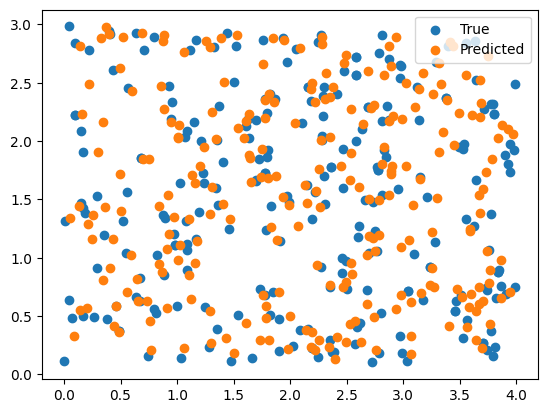

In [26]:
# Plot the results
plt.scatter(y_test[:250, 0], y_test[:250, 1], label='True')
plt.scatter(y_pred[:250, 0], y_pred[:250, 1], label='Predicted')
plt.legend()
plt.show()

***

### Προβλέψεις μέσω Νευρωνικού !!! (exciting!)

Έχουμε ``` input_size = 4000 ```

Και ```output_size = 2```

Θα φτιάξουμε ένα απλό γραμμικό μοντέλο για εξοικείωση

Το μοντέλο θα τρέξει στην GPU αν αυτή είναι διαθέσιμη.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Προετοιμάζουμε τα δεδομένα όπως και προηγουμένως με το XGB μοντέλο

In [17]:
# Reshape the tensor to 2D so that it can be used in the linear model
X = input_array.reshape(len(info_new), -1)
print(X.shape)

(5000, 4000)


In [12]:
y = rfid_label
print(y.shape)

(5000, 2)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 4000)
(1000, 4000)


Μετατρέπουμε όλα μας τα data σε torch tensors για να είναι συμβατά με την αρχιτεκτονική του μοντέλου.

In [58]:
# Transform the data to PyTorch tensors and move them to the GPU if available
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

Το μοντέλο αρχικά αποτελείται από 3 επίπεδα, με συνάρτηση ενεργοποίησης ```ReLU```.

In [81]:
from torch import nn

# Build the model

class FirstModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(FirstModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),
            nn.ReLU()   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [82]:
# Define the input and output sizes
input_len = X_train_scaled.shape[1]
output_len = y_train.shape[1]

# Instantiate the model
model_0 = FirstModel(input_size=input_len, output_size=output_len)
model_0.to(device)

FirstModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): ReLU()
  )
)

In [83]:
logits = model_0(X_train_tensor)
logits[:5]

tensor([[0.1062, 0.0000],
        [0.1113, 0.0821],
        [0.0000, 0.0482],
        [0.1189, 0.0000],
        [0.1083, 0.0000]], device='cuda:0', grad_fn=<SliceBackward0>)

Ορίζουμε την ```loss_function``` και τον ```optimizer```

In [84]:
# Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [85]:
# Fit the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1500
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    model_0.train()

    # Forward pass
    y_pred = model_0(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(X_test_tensor)
        test_loss = loss_fn(y_test_pred, y_test_tensor)
    
    train_loss_arr.append(loss)
    test_loss_arr.append(test_loss)
    # Print the metrics
    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Loss train: {loss.item()} | Loss test: {test_loss.item()}')


Epoch 0 | Loss train: 3.924311399459839 | Loss test: 2.7242989540100098
Epoch 100 | Loss train: 0.28560733795166016 | Loss test: 0.30598965287208557
Epoch 200 | Loss train: 0.17822504043579102 | Loss test: 0.19474270939826965
Epoch 300 | Loss train: 0.09287098795175552 | Loss test: 0.10555191338062286
Epoch 400 | Loss train: 0.027551038190722466 | Loss test: 0.030351100489497185
Epoch 500 | Loss train: 0.0315849706530571 | Loss test: 0.02799433469772339
Epoch 600 | Loss train: 0.017624935135245323 | Loss test: 0.02006910741329193
Epoch 700 | Loss train: 0.016520900651812553 | Loss test: 0.015523034147918224
Epoch 800 | Loss train: 0.011796065606176853 | Loss test: 0.013879475183784962
Epoch 900 | Loss train: 0.013327195309102535 | Loss test: 0.01263145450502634
Epoch 1000 | Loss train: 0.011069610714912415 | Loss test: 0.012412697076797485
Epoch 1100 | Loss train: 0.011624384671449661 | Loss test: 0.010240164585411549
Epoch 1200 | Loss train: 0.009669649414718151 | Loss test: 0.0110427

Τι ωραία νούμερα!!! Μακάρι να αντικατοπτρίζουν την πραγματικότητα.

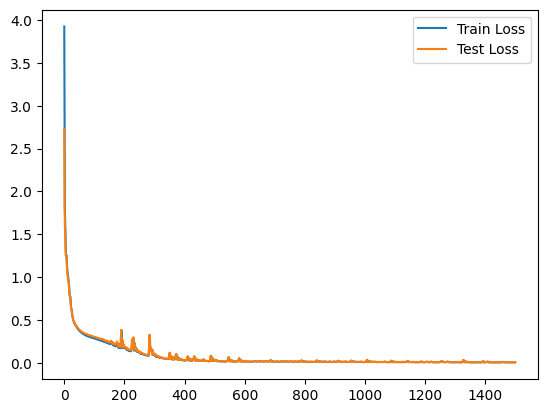

In [86]:
# Plot the loss
train_loss_arr = [i.cpu().detach().numpy() for i in train_loss_arr]
test_loss_arr = [i.cpu().detach().numpy() for i in test_loss_arr]

plt.plot(train_loss_arr, label='Train Loss')
plt.plot(test_loss_arr, label='Test Loss')
plt.legend()
plt.show()

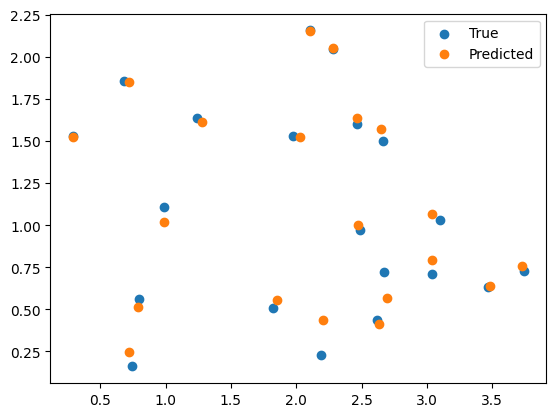

In [87]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(X_test_tensor)

# Plot the results
plt.scatter(y_test[:20, 0], y_test[:20, 1], label='True')
plt.scatter(y_pred[:20, 0].cpu().detach().numpy(), y_pred[:20, 1].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.show()

**********************